In [1]:
#June 6

import ares
import numpy as np
import matplotlib.pyplot as pl

# import GalaxyHOD

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

In [4]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
import scipy.integrate as integrate

cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)

# z_at_value(cosmo.age, 0.5 * u.Gyr)

### Main Sequence: stellar mass vs. SFR relationship  
Speagle2014 - using a compilation of 25 studies from literature  
5.1 The Evolution of the Galaxy “Main Sequence”

The interpublication scatter around this fit is σi = (0.08, 0.09, 0.11) dex, for the minimum, median, and maximum 
values within the fitted mass range logM∗ = 9.7 – 11.1, respectively. This encompasses a majority of the age of 
the Universe (z ∼ 0.25 – 2.75), and provides good fits to the observed SFRs all the way out z ∼ 5

In [5]:
pars = ares.util.ParameterBundle("emma:model1")
pop = ares.populations.GalaxyPopulation(**pars) #with my added GalaxyHOD class in ARES
# pop = GalaxyHOD.GalaxyHOD() #if you are using the OG ARES and the standalone python file

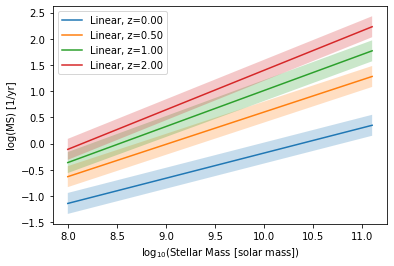

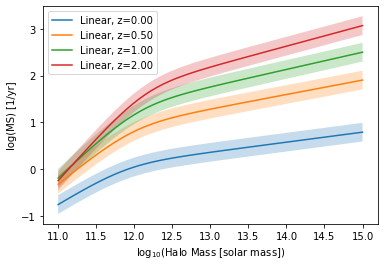

In [18]:
Sm = np.linspace(8, 11.1)

for z in [0, 0.5, 1, 2]:
    SFR = pop.SFR(z, Sm)
    error = np.ones(len(SFR)) * 0.2 #dex #the stated "true" scatter

    pl.plot(Sm, SFR, label="Linear, z=%.2f" %z)
    pl.fill_between(Sm, SFR-error, SFR+error, alpha=0.25)

pl.legend()
pl.ylabel('log(MS) [1/yr]')
pl.xlabel('log$_{10}$(Stellar Mass [solar mass])')
# pl.title('')

pl.show()

#check if giving it halo mass works
Hm = np.linspace(11, 15)

for z in [0, 0.5, 1, 2]:
    SFR = pop.SFR(z, Hm, True)
    error = np.ones(len(SFR)) * 0.2 #dex #the stated "true" scatter

    pl.plot(Hm, SFR, label="Linear, z=%.2f" %z)
    pl.fill_between(Hm, SFR-error, SFR+error, alpha=0.25)

pl.legend()
pl.ylabel('log(MS) [1/yr]')
pl.xlabel('log$_{10}$(Halo Mass [solar mass])')
# pl.title('')

pl.show()

### specific star formation rate
$SSFR = \frac{SFR}{SM}$

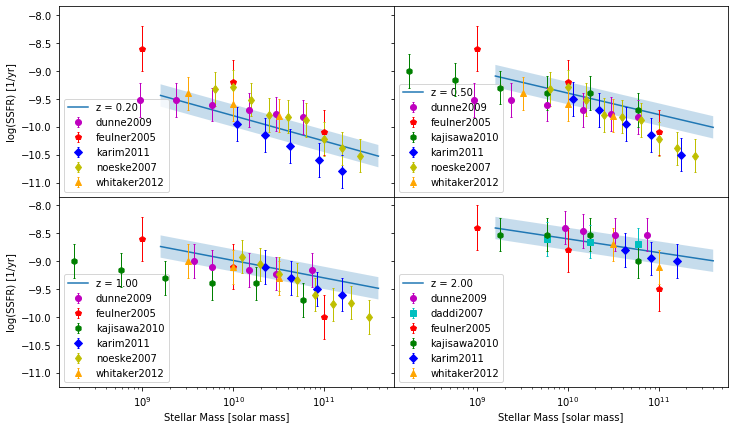

In [8]:
Sm = np.linspace(9.2, 11.6)

fig, axs = pl.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axs = axs.flatten()
pl.subplots_adjust(hspace=0, wspace=0)

for i, z in enumerate([0.2, 0.5, 1, 2]):
    
    data.PlotSSFR(z=z, round_z=0.3, ax=axs[i])
    
#     SSFR = phi(z, Sm) - np.log10(Sm)
    SSFR = pop.SSFR(z, Sm)

    error = np.ones(len(SSFR)) * 0.2
    axs[i].set_xscale('log')

    axs[i].plot(10**Sm, SSFR, label="z = %.2f" %z, )
    axs[i].fill_between(10**Sm, SSFR-error, SSFR+error, alpha=0.25)
    if i%2==0:
        axs[i].set(xlabel='Stellar Mass [solar mass]', ylabel='log(SSFR) [1/yr]')

    axs[i].legend()
axs[i].set(xlabel='Stellar Mass [solar mass]')

pl.show()

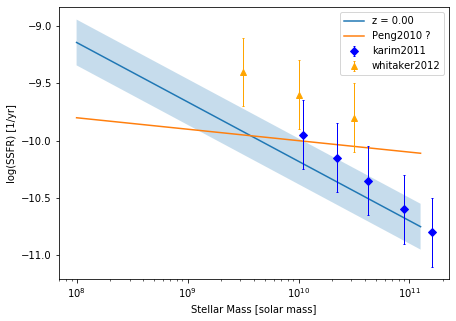

In [19]:
z = 0.0

sSFR_peng = -10.0 - 0.1*(Sm - 10.0)

fig, ax = pl.subplots(figsize=(7, 5))

data.PlotSSFR(z=z, round_z=0.3, ax=ax)

#     SSFR = phi(z, Sm) - np.log10(Sm)
SSFR = pop.SSFR(z, Sm)

error = np.ones(len(SSFR)) * 0.2
ax.set_xscale('log')

ax.plot(10**Sm, SSFR, label="z = %.2f" %z, )
ax.fill_between(10**Sm, SSFR-error, SSFR+error, alpha=0.25)
ax.set(xlabel='Stellar Mass [solar mass]', ylabel='log(SSFR) [1/yr]')

ax.plot(10**Sm, sSFR_peng, label="Peng2010 ?")

ax.legend()

pl.show()

### Cosmic SFR density (SFRD)

$$ SFRD(z) = \int SFR(z,M_s) \cdot SMF(z, M_s) dM_s \approx \sum_{M_s}[SFR(z,M_s) \cdot SMF(z, M_s) \cdot dM_s] $$ 
$dM_s$: stellar mass bin size  
SMF = number density  


In [8]:
Zs = np.linspace(0, 8, 50)
# pop.SFRD(Zs)
# pop.SFRD(1)

In [9]:
#for each mass, get sfr (sSFR) * number density of that mass
# then 'integrate' over all the masses

# pop = GalaxyHOD.GalaxyHOD()
logbins = np.linspace(9.5, 11.5)
bins = 10**logbins

Zs = np.linspace(0, 8, 50)
SFRD = []

for z in Zs:
    numberD = pop.StellarMassFunction(z, logbins, False) #need to add an option to suppress the message

    SFR = 10**pop.SFR(z, bins)/bins # cause we don't want the value loged i think?
    error = 0.2 * SFR * np.log(10)

    dbin = [] #does this get the right bins?
    for i in range(0, len(bins) - 1):
        dbin.append(bins[i+1]-bins[i])

    SFRD_val = np.sum( numberD[:-1] * SFR[:-1] * dbin )
    SFRD_err = np.sqrt(np.sum( numberD[:-1] * dbin * error[:-1])**2)
    
    SFRD.append([SFRD_val, SFRD_err])

SFRD = np.transpose(SFRD) # [sfrd, err]

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.


In [23]:
# importing some data from behroozi-2013: csfrs_new.dat
# Columns: redshift, Log10(CSFR) (Msun/yr/Mpc^3), Err+ (dex), Err- (dex)
import UsefulHODFunctions as UHF
csfrs, err = UHF.getCsfrsData()

Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
50


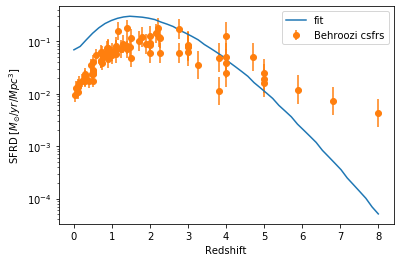

In [22]:
# Zs = np.linspace(0, 8, 50)
SFRD_mod = pop.SFRD(Zs)

# pl.semilogy(Zs, SFRD[0], label="model")
# pl.fill_between(Zs, SFRD[0]-SFRD[1], SFRD[0]+SFRD[1], alpha=0.25) #do these do the logy axis properly?

pl.semilogy(Zs, SFRD_mod, label="fit")

pl.errorbar(csfrs[0], 10**csfrs[1], yerr=[err[0], err[1]], ls="", marker="o", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.show()